In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

import torch
import scipy.sparse as sp
import glob
import warnings
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd
from tqdm import tqdm
import pickle
from sklearn.preprocessing import MinMaxScaler

In [3]:
import spaceoracle

2024-11-19 19:29:08.171713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [105]:
# adata_train = sc.read_h5ad(
#     '/ihome/ylee/kor11/space/SpaceOracle/notebooks/cache/adata_train.h5ad')

adata_train = sc.read_h5ad('.cache/adata_train.h5ad')

adata_train

AnnData object with n_obs × n_vars = 11567 × 5013
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [6]:
so = spaceoracle.SpaceOracle(
    adata=adata_train,
    annot='rctd_cluster', 
    max_epochs=200, 
    learning_rate=5e-4, 
    spatial_dim=64,
    batch_size=512,
    threshold_lambda=1e-4,
    test_mode=False,
    # save_dir='/ix/djishnu/shared/djishnu_kor11/models'
    save_dir='/Users/koush/Downloads/models', 
    radius=200
)


In [7]:
so.queue

OracleQueue with 0 remaining genes

In [8]:
import gc
del so.beta_dict 
so.beta_dict = None
gc.collect()

32

In [9]:
so.beta_dict = so._get_spatial_betas_dict()

Estimating betas globally: 100%|██████████| 3125/3125 [00:46<00:00, 66.86it/s]


: 

In [10]:
disturbed = so.perturb(target='Pax5')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Running simulation 1/3:  61%|██████▏   | 7086/11567 [09:22<04:09, 17.99it/s]

In [4]:
%load_ext autoreload
%autoreload 2

import sys
import scanpy as sc
sys.path.append('../src')
from spaceoracle.beta import Betabase

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# from perplexity import Perplexity
# import json

# perplexity = Perplexity()
# answer = perplexity.search("In a few sentences, describe what the Pax5 gene does.")
# answer = list(answer)
# print(json.loads(answer[-1]['text'])['answer'])
# perplexity.close()

In [5]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data/day3_lymph_rep_1.h5ad')

In [6]:
bdb = Betabase(adata, '/ix/djishnu/shared/djishnu_kor11/models_v2')

 44%|████▍     | 882/2000 [01:35<02:00,  9.25it/s]


KeyboardInterrupt: 

In [7]:
import pandas as pd
import numpy as np

from spaceoracle.models.parallel_estimators import received_ligands

class BetaFrame(pd.DataFrame):

    @classmethod
    def from_path(cls, path):
        df = pd.read_parquet(path)
        return cls(df)

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.prefix = 'beta_'
        self.tfs = []
        self.lr_pairs = []
        self.tfl_pairs = []
        
        for col in self.columns:
            if col.startswith(self.prefix):
                modulator = col[len(self.prefix):]
                if '$' in modulator:
                    self.lr_pairs.append(modulator)
                elif '#' in modulator:
                    self.tfl_pairs.append(modulator) 
                else:
                    self.tfs.append(modulator)

        self.ligands, self.receptors = zip(
            *[p.split('$') for p in self.lr_pairs]) if self.lr_pairs else ([], [])
        self.tfl_ligands, self.tfl_regulators = zip(
            *[p.split('#') for p in self.tfl_pairs]) if self.tfl_pairs else ([], [])
        self.ligands = list(self.ligands)
        self.receptors = list(self.receptors)
        self.tfl_ligands = list(self.tfl_ligands)
        self.tfl_regulators = list(self.tfl_regulators)
        self.modulators_genes = [f'beta_{m}' for m in np.unique(
            self.tfs + self.ligands + self.receptors + self.tfl_ligands + self.tfl_regulators)]
        
        self._all_ligands = np.unique(list(self.ligands) + list(self.tfl_ligands))

        self.df_lr_columns = [f'beta_{r}' for r in self.receptors]+[f'beta_{l}' for l in self.ligands]
        self.df_tfl_columns = [f'beta_{r}' for r in self.tfl_regulators]+[f'beta_{l}' for l in self.tfl_ligands]
        self.tf_columns = [f'beta_{t}' for t in self.tfs]
    

    def splash_1(self, rw_ligands, gex_df):
        _df = pd.DataFrame(
            np.concatenate([
                self[self.tf_columns].to_numpy(),
                self[[f'beta_{a}${b}' for a, b in zip(self.ligands, self.receptors)]*2].to_numpy() * \
                    rw_ligands[self.ligands].join(gex_df[self.receptors]).to_numpy(),
                self[[f'beta_{a}#{b}' for a, b in zip(self.tfl_ligands, self.tfl_regulators)]*2].to_numpy() * \
                    rw_ligands[self.tfl_ligands].join(gex_df[self.tfl_regulators]).to_numpy()
            ], axis=1),
            index=self.index,
            columns=self.tf_columns + self.df_lr_columns + self.df_tfl_columns
        ).groupby(lambda x: x, axis=1).sum()

        return _df[self.modulators_genes]
        
    def _repr_html_(self):
        info = f"BetaFrame with {len(self.modulators_genes)} modulator genes\n"
        df_html = super()._repr_html_()
        return f"<div><p>{info}</p>{df_html}</div>"


In [8]:
import glob

In [11]:
# adata_train = sc.read_h5ad('.cache/adata_train.h5ad')

In [12]:
from tqdm import tqdm

In [ ]:
fnames = list(glob.glob(''/ix/djishnu/shared/djishnu_kor11/models_v2/*.parquet'))
beta_dict = {}
ligands_set = set()

for path in tqdm(fnames):
    gene_name = path.split('/')[-1].split('_')[0]
    beta_dict[gene_name] = BetaFrame.from_path(path)
    ligands_set.update(beta_dict[gene_name]._all_ligands)

0it [00:00, ?it/s]


In [141]:
collected = []
collected_genes = []
for k in beta_dict.keys():
    if 'beta_Pax5' in beta_dict[k].modulators_genes:
        collected.append(beta_dict[k]['beta_Pax5'])
        collected_genes.append(k+'_Pax5')


In [168]:
r = pd.concat(collected, axis=1, keys=collected_genes).mean(1).to_frame().join(
    pd.DataFrame(adata_train.obsm['spatial'], columns=['x', 'y'], index=adata_train.obs_names))

<Axes: xlabel='rctd_celltypes'>

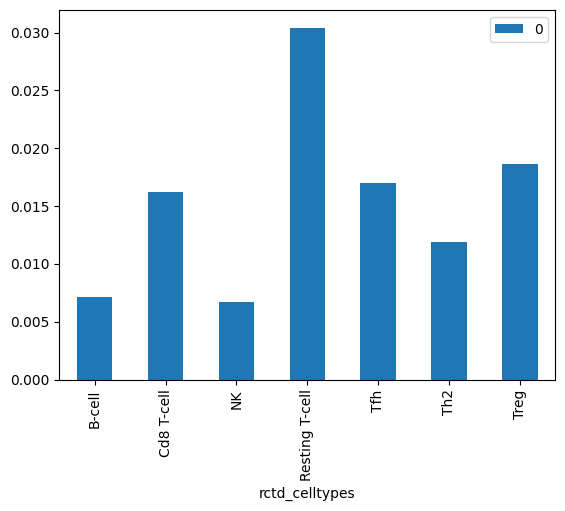

: 

In [176]:
pd.concat(collected, axis=1, keys=collected_genes).mean(1).to_frame().join(
    adata_train.obs['rctd_celltypes']).groupby('rctd_celltypes').mean().plot.bar()

In [147]:
import seaborn as sns

In [153]:
r

,Lyrm7_Pax5,Sod1_Pax5,H2-Ob_Pax5,Zfp566_Pax5,Tpd52_Pax5,Pfdn2_Pax5,Ubqln4_Pax5,Ticam2_Pax5,Eif3g_Pax5,Mmaa_Pax5,...,Arl6ip4_Pax5,Jarid2_Pax5,Txndc15_Pax5,Rbmx2_Pax5,Zfp953_Pax5,Mis12_Pax5,Higd1a_Pax5,Grn_Pax5,x,y
AAAAAACGGTAGAT,0.037375,0.000000,0.066725,0.216297,0.065470,-0.067880,0.152971,-0.114294,-0.070639,0.0,...,0.012443,0.101352,-0.000000,0.208895,0.000000,-0.000000,-0.006210,-0.000000,NaN,NaN
AAAAAATCCGGCGA,-0.000000,-0.246606,0.038477,0.000000,0.013125,0.029791,-0.000000,0.056217,0.090356,-0.0,...,-0.082522,-0.203048,-0.000000,0.060801,0.015550,0.000000,0.000000,-0.039238,NaN,NaN
AAAAACCGTCAGAC,0.051175,0.000000,0.063322,0.215433,0.091228,-0.078750,0.184016,-0.066979,-0.048771,0.0,...,0.002724,0.090887,-0.000000,0.186683,0.000000,0.000000,0.009324,-0.000000,NaN,NaN
AAAAACGCTCCGAC,0.057433,0.000000,0.063646,0.203264,0.093101,-0.076908,0.191452,-0.072037,-0.054328,0.0,...,0.007752,0.088086,-0.000000,0.184650,-0.000000,-0.000000,0.007435,-0.000000,NaN,NaN
AAAAAGCACGTGTT,0.049457,0.000000,0.062476,0.214229,0.082635,-0.079852,0.160121,-0.044943,-0.070687,0.0,...,0.010856,0.099494,-0.000000,0.169938,0.000000,-0.000000,-0.002579,-0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTCGCGGCTA,-0.000000,-0.240910,0.035780,-0.000000,0.012805,0.034420,-0.000000,0.087180,0.079646,-0.0,...,-0.058109,-0.114920,-0.000000,0.060243,0.013103,0.000000,-0.000000,-0.031998,NaN,NaN
TTTTTTGGGCTGGT,-0.002771,-0.000000,0.079461,-0.000000,0.141801,0.277158,-0.008350,-0.000000,-0.103912,-0.0,...,-0.254346,0.001649,0.047540,-0.000000,-0.047415,-0.007140,0.000000,0.000000,NaN,NaN
TTTTTTGTACCCAC,-0.025784,-0.000000,0.090493,-0.000000,0.134529,0.150251,-0.008035,0.000000,-0.111933,-0.0,...,-0.267400,-0.002280,0.055248,-0.000000,-0.038059,-0.029534,0.000000,0.000000,NaN,NaN
TTTTTTGTACGATT,0.012979,0.000000,0.081097,0.153049,0.046992,-0.070882,0.080003,-0.106922,-0.019858,0.0,...,-0.015134,0.086842,-0.000000,0.167807,-0.000000,0.000000,0.012601,-0.000000,NaN,NaN


In [156]:
r

,Lyrm7_Pax5,Sod1_Pax5,H2-Ob_Pax5,Zfp566_Pax5,Tpd52_Pax5,Pfdn2_Pax5,Ubqln4_Pax5,Ticam2_Pax5,Eif3g_Pax5,Mmaa_Pax5,...,Arl6ip4_Pax5,Jarid2_Pax5,Txndc15_Pax5,Rbmx2_Pax5,Zfp953_Pax5,Mis12_Pax5,Higd1a_Pax5,Grn_Pax5,x,y
AAAAAACGGTAGAT,0.037375,0.000000,0.066725,0.216297,0.065470,-0.067880,0.152971,-0.114294,-0.070639,0.0,...,0.012443,0.101352,-0.000000,0.208895,0.000000,-0.000000,-0.006210,-0.000000,NaN,NaN
AAAAAATCCGGCGA,-0.000000,-0.246606,0.038477,0.000000,0.013125,0.029791,-0.000000,0.056217,0.090356,-0.0,...,-0.082522,-0.203048,-0.000000,0.060801,0.015550,0.000000,0.000000,-0.039238,NaN,NaN
AAAAACCGTCAGAC,0.051175,0.000000,0.063322,0.215433,0.091228,-0.078750,0.184016,-0.066979,-0.048771,0.0,...,0.002724,0.090887,-0.000000,0.186683,0.000000,0.000000,0.009324,-0.000000,NaN,NaN
AAAAACGCTCCGAC,0.057433,0.000000,0.063646,0.203264,0.093101,-0.076908,0.191452,-0.072037,-0.054328,0.0,...,0.007752,0.088086,-0.000000,0.184650,-0.000000,-0.000000,0.007435,-0.000000,NaN,NaN
AAAAAGCACGTGTT,0.049457,0.000000,0.062476,0.214229,0.082635,-0.079852,0.160121,-0.044943,-0.070687,0.0,...,0.010856,0.099494,-0.000000,0.169938,0.000000,-0.000000,-0.002579,-0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTCGCGGCTA,-0.000000,-0.240910,0.035780,-0.000000,0.012805,0.034420,-0.000000,0.087180,0.079646,-0.0,...,-0.058109,-0.114920,-0.000000,0.060243,0.013103,0.000000,-0.000000,-0.031998,NaN,NaN
TTTTTTGGGCTGGT,-0.002771,-0.000000,0.079461,-0.000000,0.141801,0.277158,-0.008350,-0.000000,-0.103912,-0.0,...,-0.254346,0.001649,0.047540,-0.000000,-0.047415,-0.007140,0.000000,0.000000,NaN,NaN
TTTTTTGTACCCAC,-0.025784,-0.000000,0.090493,-0.000000,0.134529,0.150251,-0.008035,0.000000,-0.111933,-0.0,...,-0.267400,-0.002280,0.055248,-0.000000,-0.038059,-0.029534,0.000000,0.000000,NaN,NaN
TTTTTTGTACGATT,0.012979,0.000000,0.081097,0.153049,0.046992,-0.070882,0.080003,-0.106922,-0.019858,0.0,...,-0.015134,0.086842,-0.000000,0.167807,-0.000000,0.000000,0.012601,-0.000000,NaN,NaN


<Axes: xlabel='x', ylabel='y'>

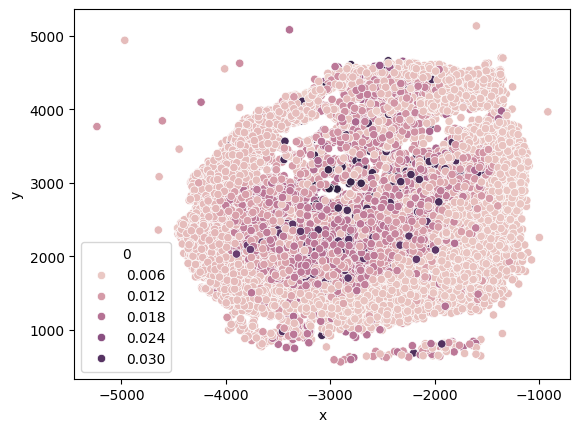

In [169]:
sns.scatterplot(data=r, x='x', y='y', hue=0)

In [128]:
rw_ligands = received_ligands(
    xy=adata_train.obsm['spatial'], 
    lig_df=adata_train.to_df(layer='imputed_count')[list(ligands_set)],
    radius=200
)

gex_df =adata_train.to_df(layer='imputed_count')

In [129]:
for path in tqdm(fnames):
    g = path.split('/')[-1].split('_')[0]
    x_ = beta_dict[g].splash_1(
        rw_ligands=rw_ligands, 
        gex_df=gex_df
    )

100%|██████████| 2811/2811 [03:00<00:00, 15.55it/s]


In [117]:
%%timeit

x_ = beta_dict[g].splash(
        rw_ligands=rw_ligands, 
        gex_df=gex_df
    )

858 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [131]:
x_.sample(20).style.text_gradient(cmap='rainbow', axis=0)

,beta_Angptl2,beta_Angptl4,beta_Atf3,beta_Bach1,beta_Batf3,beta_Bcl11a,beta_Bcl11b,beta_Bclaf1,beta_Bhlhe41,beta_Brf1,beta_C3,beta_C4b,beta_Cebpa,beta_Cebpb,beta_Clcf1,beta_Clock,beta_Cr2,beta_Crebzf,beta_Csf1,beta_Csf1r,beta_Ctcf,beta_Cxcl12,beta_Cxcl13,beta_Cxcr4,beta_Cxcr5,beta_E2f7,beta_Ebf1,beta_Ebf3,beta_Ebi3,beta_Egr1,beta_Egr2,beta_Egr3,beta_Elk1,beta_Erg,beta_Fos,beta_Fosl2,beta_Gata2,beta_Glis2,beta_Gtf3c2,beta_Hdac2,beta_Heyl,beta_Hic1,beta_Hivep1,beta_Id1,beta_Id2,beta_Igf1,beta_Il15,beta_Il2,beta_Il21,beta_Il21r,beta_Il27ra,beta_Il2ra,beta_Il2rb,beta_Il2rg,beta_Il4,beta_Il4ra,beta_Il6st,beta_Il7,beta_Il7r,beta_Insm1,beta_Irf5,beta_Irf7,beta_Irf8,beta_Irf9,beta_Itga6,beta_Klf13,beta_Klf4,beta_Klf7,beta_Klf9,beta_Lif,beta_Max,beta_Mef2a,beta_Mef2c,beta_Mnt,beta_Ncl,beta_Nfe2l2,beta_Nr2c2,beta_Nr2f2,beta_Nr3c1,beta_Osm,beta_Pax5,beta_Pbx3,beta_Pirb,beta_Pou2f2,beta_Ptn,beta_Pura,beta_Rreb1,beta_Runx1,beta_Runx2,beta_Rxra,beta_Sdc4,beta_Setdb1,beta_Smad1,beta_Stat2,beta_Taf1,beta_Tal1,beta_Tbp,beta_Tcf3,beta_Tcf7l2,beta_Tfe3,beta_Tnfrsf13c,beta_Tnfsf13b,beta_Vezf1,beta_Xbp1,beta_Zbtb17,beta_Zfp263,beta_Zfp740,beta_Zkscan1,beta_Zscan22
GGTGCTGGCCCTTC,0.000000,-0.004248,0.353233,0.050341,0.010934,-0.043381,0.022371,-0.005198,0.109689,0.000000,0.000000,0.000000,-0.073920,-0.119525,-0.009371,-0.003333,0.000000,0.015121,0.001465,0.041105,-0.286797,-0.002637,0.000000,-0.062558,0.000000,0.065580,0.065491,0.000000,-0.012533,-0.146441,-0.172001,0.019865,0.000000,0.122263,0.096088,0.023677,0.000000,0.030742,0.063499,0.156591,0.058569,-0.012409,-0.032253,-0.062150,-0.067207,0.001945,-0.001799,-0.003537,0.012831,0.140739,-0.064890,0.000000,0.000000,0.031218,0.002828,0.291461,-0.003744,-0.000865,0.043640,-0.112727,0.007831,-0.467733,-0.056734,0.137659,0.000000,0.017179,-0.119116,-0.172162,-0.051609,0.003323,0.040247,-0.133708,-0.212274,0.105813,-0.004525,0.070521,0.000000,0.129456,-0.053071,-0.000370,-0.019543,0.000000,0.000000,0.007212,-0.007288,-0.014067,0.091486,-0.027769,0.028678,-0.117066,0.115975,0.000988,0.061487,0.008048,0.000000,0.097549,0.025496,0.002309,0.190448,-0.015415,0.026888,0.006716,-0.046508,-0.050497,0.184234,0.000000,0.000000,-0.044162,0.000000
CCCGAAAACTGTCA,0.000000,-0.002476,0.073783,0.001016,0.044463,-0.036490,0.032417,-0.003535,0.061502,0.000000,0.000000,0.000000,-0.103034,-0.044147,-0.005915,-0.022257,0.000000,-0.023879,0.000968,0.026052,-0.208012,-0.001700,0.000000,-0.034435,0.000000,0.038086,0.076951,0.000000,-0.010136,-0.018832,-0.148363,0.032567,0.000000,0.056616,0.075202,0.023109,0.000000,0.017443,0.054844,0.116122,0.078398,-0.046420,-0.025612,-0.055418,-0.032258,0.001762,-0.001414,-0.002021,0.009470,0.121702,-0.066377,0.000000,0.000000,0.031381,0.006080,0.382373,0.004262,-0.000252,0.043651,-0.039236,0.054919,-0.323310,-0.040315,0.116383,0.000000,0.039738,-0.036122,-0.116060,-0.005969,0.001547,0.042470,-0.113894,-0.207089,0.017584,0.001832,0.042808,0.000000,0.050284,-0.016589,-0.000255,-0.005686,0.000000,0.000000,0.020890,0.004497,-0.012750,0.057438,-0.039666,0.009882,-0.098941,0.073359,0.014001,0.037394,-0.008051,0.000000,0.065328,0.015053,0.001562,0.051845,-0.019945,0.018092,0.005217,-0.006672,-0.094519,0.108304,0.000000,0.000000,-0.026468,0.000000
GTCAGGTGACACTG,0.000000,-0.003449,0.072459,0.035712,0.037174,-0.047257,0.033785,-0.004381,0.070560,0.000000,0.000000,0.000000,-0.017830,-0.017948,-0.004633,-0.027707,0.000000,-0.019302,0.000673,0.027403,-0.221856,-0.001515,0.000000,-0.023554,0.000000,0.023210,0.061926,0.000000,-0.013325,0.029857,-0.148313,0.044151,0.000000,-0.002377,0.049530,0.012387,0.000000,0.012237,0.035728,0.087293,0.083924,-0.044584,-0.023704,-0.076254,-0.038910,0.000578,-0.006014,-0.001496,0.008294,0.085190,-0.066721,0.000000,0.000000,0.026753,0.007120,0.417473,0.002119,-0.000715,0.034646,-0.039945,0.040815,-0.280610,-0.026007,0.111358,0.000000,0.011409,-0.083293,-0.143338,0.021733,0.002037,0.046693,-0.095439,-0.184315,0.002333,0.003922,0.054572,0.000000,0.092439,0.012073,0.000088

In [52]:
bdf.splash(
    gex_df=adata.to_df(layer='imputed_count'), 
    xy=adata.obsm['spatial']
)

,beta_Angptl4,beta_Bcl11a,beta_C3,beta_C4b,beta_Cr2,beta_Csf1,beta_Csf1r,beta_Ebi3,beta_Erg,beta_Foxp3,...,beta_Nfib,beta_Osm,beta_Pax5,beta_Runx2,beta_Rxra,beta_Sdc4,beta_Taf1,beta_Tnfrsf13c,beta_Tnfsf13b,beta_Zfp523
AAAAAACGGTAGAT,0.000010,-0.000950,-0.0,-0.0,-0.0,-0.000093,-0.005318,0.000288,-0.001421,0.015615,...,-0.001065,0.000015,-0.001138,0.012262,7.256228e-07,-0.004674,0.002673,-0.001135,-0.000098,-0.004023
AAAAAATCCGGCGA,-0.000004,-0.031601,-0.0,0.0,0.0,-0.000180,-0.014642,0.000063,-0.000083,-0.004540,...,-0.021817,0.000231,0.006657,0.036909,0.000000e+00,-0.015727,0.010994,0.000000,0.000000,0.000000
AAAAACCGTCAGAC,0.000033,-0.000613,-0.0,-0.0,-0.0,-0.000069,-0.004507,-0.000034,-0.002572,0.027339,...,-0.001430,0.000004,-0.001029,0.014621,3.209319e-04,-0.002435,0.002111,-0.000908,-0.000313,-0.007023
AAAAACGCTCCGAC,0.000029,-0.000963,-0.0,-0.0,-0.0,-0.000056,-0.008250,-0.000192,-0.002635,0.022627,...,-0.001010,0.000030,-0.001430,0.016394,2.273195e-04,-0.002565,0.003238,-0.000537,-0.000291,-0.009777
AAAAAGCACGTGTT,0.000057,-0.001362,-0.0,-0.0,-0.0,-0.000063,-0.010808,0.000198,-0.002788,0.029944,...,-0.002471,0.000012,-0.001842,0.019274,2.223014e-04,-0.005715,0.003913,-0.001140,-0.000177,-0.008614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTCGCGGCTA,0.000365,-0.024830,-0.0,0.0,0.0,-0.000808,-0.041534,-0.001466,-0.000434,-0.003522,...,-0.027212,0.000217,0.006164,0.030978,0.000000e+00,-0.013636,0.005165,0.000000,0.000000,0.000000
TTTTTTGGGCTGGT,0.000013,-0.030365,0.0,-0.0,0.0,-0.000337,-0.020256,-0.002555,0.000000,-0.012733,...,0.004702,0.000459,0.004192,0.047048,1.918845e-02,-0.032496,0.001788,0.000000,0.000000,-0.104555
TTTTTTGTACCCAC,-0.000061,-0.009895,0.0,0.0,0.0,-0.000358,-0.018270,-0.000596,0.000000,-0.003740,...,0.002531,0.000314,0.001530,0.043468,1.467518e-02,-0.024477,0.001450,0.000000,0.000000,-0.156852
TTTTTTGTACGATT,-0.000666,-0.009459,0.0,-0.0,0.0,-0.000529,-0.021356,0.000877,-0.006278,0.004005,...,-0.002448,0.000113,-0.003632,0.037813,-1.584334e-04,-0.023998,0.017460,-0.005058,-0.001606,-0.009798


In [51]:
bdf.splash(
    gex_df=adata.to_df(layer='imputed_count'), 
    xy=adata.obsm['spatial']
).mean(0).sort_values(ascending=False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


beta_Runx2        0.024595
beta_Il2rb        0.017873
beta_Foxp3        0.008478
beta_Taf1         0.004393
beta_Rxra         0.003182
beta_Klf7         0.002509
beta_Nfib         0.002009
beta_Il27ra       0.001051
beta_Il2          0.000229
beta_Osm          0.000115
beta_Lif          0.000009
beta_Il4ra        0.000000
beta_C3           0.000000
beta_C4b         -0.000011
beta_Il15        -0.000028
beta_Angptl4     -0.000073
beta_Il21        -0.000130
beta_Ebi3        -0.000139
beta_Il4         -0.000139
beta_Csf1        -0.000216
beta_Tnfsf13b    -0.000375
beta_Il7         -0.000534
beta_Erg         -0.000658
beta_Il2rg       -0.000990
beta_Il21r       -0.001015
beta_Tnfrsf13c   -0.001052
beta_Pax5        -0.001994
beta_Cr2         -0.003479
beta_Il6st       -0.004595
beta_Il7r        -0.005719
beta_Bcl11a      -0.006529
beta_Csf1r       -0.008792
beta_Sdc4        -0.013540
beta_Zfp523      -0.030618
dtype: float64

In [83]:
bdf.weigh_ligands(
    gex_df=adata.to_df(layer='imputed_count'), 
    xy=adata.obsm['spatial']
)[bdf.modulators_genes]

,beta_Ackr1,beta_Ackr4,beta_Acvr2a,beta_Angpt2,beta_Angptl4,beta_Atf3,beta_Bcl11a,beta_Bcl11b,beta_Bcl6,beta_Bclaf1,...,beta_Stat2,beta_Taf1,beta_Tal1,beta_Tnfrsf13c,beta_Tnfrsf1a,beta_Tnfsf13b,beta_Tnfsf14,beta_Zbtb17,beta_Zbtb6,beta_Zfp524
AAAAAACGGTAGAT,0.000000,0.000000,0.0,0.0,0.000981,-0.320452,0.397171,-0.256767,0.216155,-0.001554,...,0.006620,0.156506,0.0,0.006428,-0.221195,0.000556,0.000000,0.000000,-0.238871,-0.443935
AAAAAATCCGGCGA,0.145340,-0.335220,0.0,0.0,0.001358,-0.450608,0.433104,-0.014035,0.115154,-0.068741,...,0.124716,-0.015101,0.0,0.054908,-0.240121,0.004474,0.000071,-0.027496,-0.000855,0.000000
AAAAACCGTCAGAC,0.000000,0.000000,0.0,0.0,-0.002402,-0.695259,0.447106,-0.208126,0.356927,0.015254,...,-0.020049,0.137771,0.0,0.012549,-0.563766,0.004332,0.000000,0.000000,-0.397594,-0.637080
AAAAACGCTCCGAC,0.000000,0.000000,0.0,0.0,0.001766,-0.639061,0.445282,-0.212772,0.343034,0.019615,...,-0.022797,0.130751,0.0,0.006830,-0.540682,0.003702,0.000000,0.000000,-0.380032,-0.614458
AAAAAGCACGTGTT,0.000000,0.000000,0.0,0.0,0.000604,-0.683383,0.373567,-0.286393,0.338731,0.011886,...,-0.012717,0.134601,0.0,0.015628,-0.585307,0.002430,0.000000,0.000000,-0.286633,-0.499583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTCGCGGCTA,2.320121,-4.707244,0.0,0.0,0.005407,-0.472727,0.532211,-0.031584,0.114334,-0.050320,...,0.136480,-0.007001,0.0,0.099650,-0.181900,0.035111,0.000118,-0.016492,0.002821,0.000000
TTTTTTGGGCTGGT,0.000000,0.000000,0.0,0.0,0.000355,-0.543547,0.305349,-0.035020,0.037225,0.062648,...,0.014985,-0.000552,0.0,0.145595,-0.006606,0.006366,-0.000023,0.011021,0.029299,-0.021242
TTTTTTGTACCCAC,0.000000,0.000000,0.0,0.0,0.000495,-0.399346,0.329070,-0.015786,0.039262,0.054385,...,-0.004196,0.000225,0.0,0.082453,-0.005845,0.012271,-0.000028,0.004751,0.022684,-0.021668
TTTTTTGTACGATT,0.000000,0.000000,0.0,0.0,0.007866,-0.398417,0.455640,-0.075533,0.187285,-0.008386,...,0.029484,0.067011,0.0,0.005912,-0.161979,0.001877,0.000000,0.000000,-0.232399,-0.403620


In [63]:
bdf.lr_pairs

['Gdf10$Acvr2a',
 'Ccl8$Ccr2',
 'Ccl6$Ccr2',
 'Ccl7$Ccr2',
 'Ccl2$Ccr2',
 'Ccl4$Ccr5',
 'Ccl5$Ccr5',
 'Ccl8$Ccr5',
 'Ccl20$Ccr6',
 'Ccl8$Ackr4',
 'Ccl2$Ackr1',
 'Ccl5$Ackr1',
 'Ccl7$Ackr1',
 'Ccl8$Ackr1',
 'Ccl11$Ackr1',
 'Cxcl1$Cxcr2',
 'Cxcl1$Ackr1',
 'Cxcl9$Ackr1',
 'Cxcl13$Ackr1',
 'Il2$Il2ra',
 'Il2$Il2rb',
 'Il2$Il2rg',
 'Il4$Il4ra',
 'Il4$Il2rg',
 'Il7$Il7r',
 'Il7$Il2rg',
 'Il15$Il15ra',
 'Il15$Il2rb',
 'Il15$Il2rg',
 'Il21$Il21r',
 'Il21$Il2rg',
 'Il4$Il13ra1',
 'Il4$Il13ra2',
 'Il12b$Il12rb1',
 'Ebi3$Il27ra',
 'Ebi3$Il6st',
 'Lif$Il6st',
 'Osm$Il6st',
 'Osm$Osmr',
 'Il24$Il20rb',
 'Csf1$Csf1r',
 'Lta$Tnfrsf1a',
 'Lta$Ltbr',
 'Tnfsf14$Ltbr',
 'Tnfsf13b$Tnfrsf13c',
 'Angptl4$Itga5',
 'Angptl4$Cdh5',
 'Angptl4$Sdc2',
 'Angptl4$Sdc4',
 'Angpt2$Itga5',
 'C3$Cr2',
 'C3$Itgam',
 'C4b$Cr2',
 'Gzma$F2rl2',
 'Gzma$Pard3',
 'Sema3a$Plxna3',
 'Sema3d$Plxna3',
 'Sema3d$Nrp2']

In [60]:
bdf.weigh_ligands(gex_df=adata.layers['imputed_count'], xy=adata.obsm['spatial'])


IndexError: arrays used as indices must be of integer (or boolean) type